# Deep Learning Template

I've attempted to extract all the valuable snippets of code provided by Jesper. (Almost) no theory here - it's all in my Notion. Enjoy!

# Solution to Hands-on

### Exercise A

To start, I load the dataset into my Python enviroment via tensorflow. It should be noted that this code also randomly shuffles each dataset (note that a seed is given).

In [24]:
import tensorflow as tf

# Path to the directory where the datasets are located
dataset_path = "/Users/pawelgach/Documents/Aarhus Uni/Machine Learning II/HandsOn/realwaste-main/RealWaste"

# Load and create training and validation sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # As per Single et al. - to be discussed in next question
    subset="training",
    seed=123,
    image_size=(524, 524),
    batch_size=32) # Batch size should match the one in the model down below

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(524, 524),
    batch_size=32)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


For a randomised visual inspection, we can implement a function that will randomly select 9 images and display them together with their labels. To make it simpler to understand, they are:

- 0 - Cardboard
- 1 - Food Organics
- 2 - Glass
- 3 - Metal
- 4 - Miscellaneous Trash
- 5 - Paper
- 6 - Plastic
- 7 - Textile Trash
- 8 - Vegetation

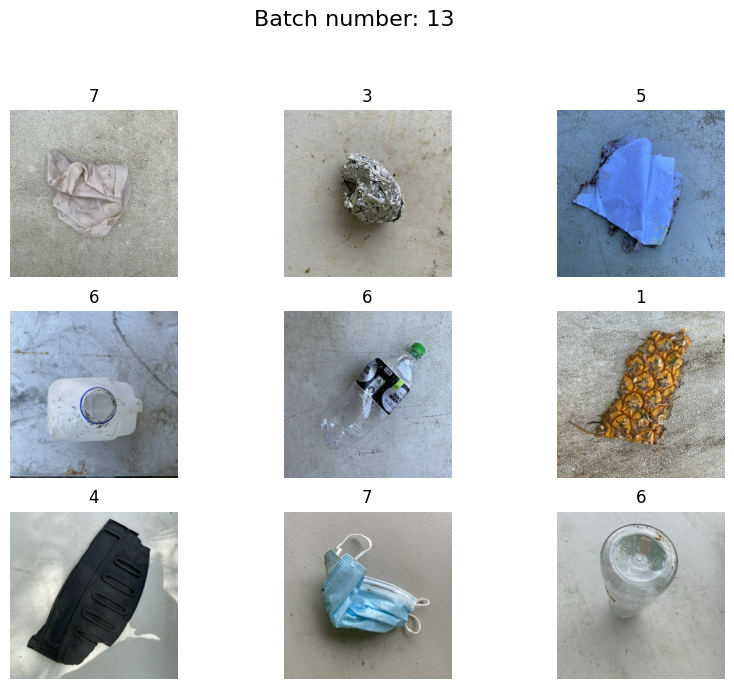

In [52]:
import matplotlib.pyplot as plt
import random

batches = tf.data.experimental.cardinality(train_dataset).numpy() # amount of all batches
random_batch_index = random.randint(0, batches - 1) # select random batch

def plot_images(dataset, batch_index, num_images):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Batch number: {batch_index}", fontsize=16)
    
    for i, (images, labels) in enumerate(dataset): # Selecting matching batch
        if i == batch_index:
            for j in range(min(num_images, len(images))):
                ax = plt.subplot((num_images // 3) + 1, 3, j + 1)
                plt.imshow(images[j].numpy().astype("uint8"))
                plt.title(int(labels[j]))
                plt.axis("off")
            break

    plt.show()

plot_images(train_dataset, random_batch_index, 9) # '9' here can be adjusted, I chose 9 for symmetry

Upon initial visual exploration, the dataset seems to be fairly well organised. However, the Misc Trash section seems full of diverse, hard to classify items which may make it more difficult to generalise on other categories. Vegetation and Food might also be confused, as they are both organic items that share some ambigous features

For a deeper insight, I can also display a histogram of the pixel values of an image, ranging from 0 (black) to 255 (white). This will let me roughly inspect the brightness of the images, and perhaps let me detect some anomalies

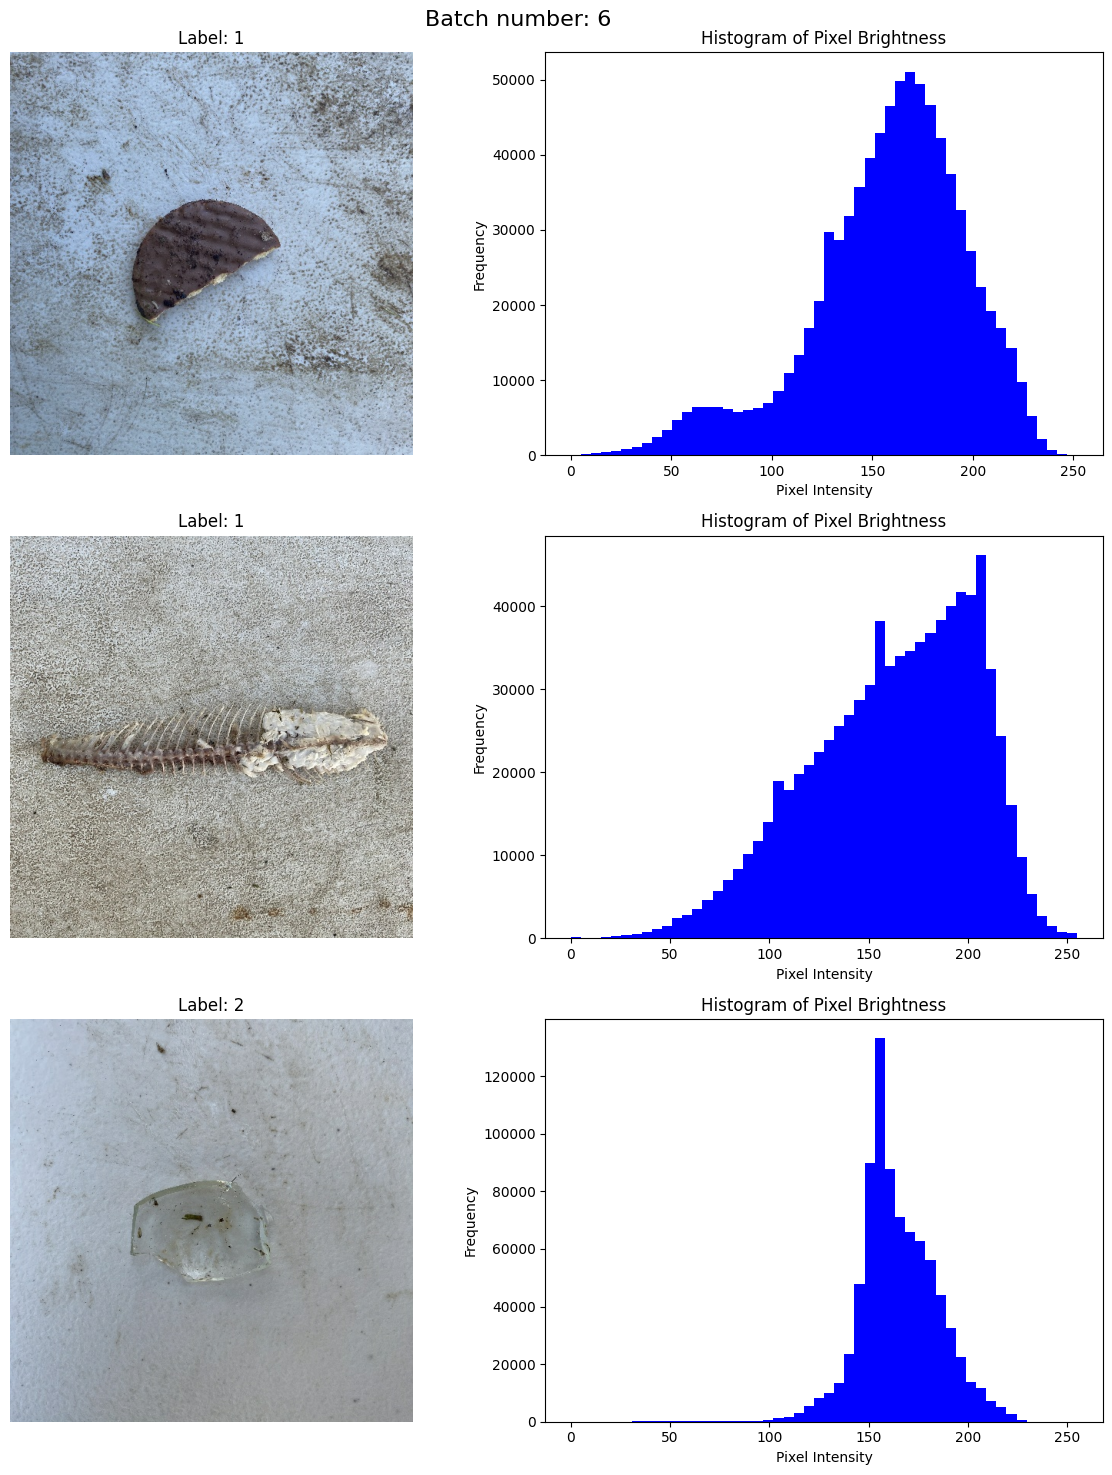

In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Similar logic as above
batches = tf.data.experimental.cardinality(train_dataset).numpy()
random_batch_index = random.randint(0, batches - 1)

def display_image_and_histogram(dataset, batch_index, num_images=1):
    plt.figure(figsize=(12, 5 * num_images))
    plt.suptitle(f"Batch number: {batch_index}", fontsize=16)
    
    for i, (images, labels) in enumerate(dataset):
        if i == batch_index:
            for j in range(min(num_images, len(images))):
                image = images[j]
                label = labels[j].numpy()

                # Display the image
                ax = plt.subplot(num_images, 2, 2 * j + 1)
                ax.imshow(image.numpy().astype("uint8"))
                ax.title.set_text(f'Label: {label}')
                ax.axis("off")

                # Display the histogram of the pixels
                ax2 = plt.subplot(num_images, 2, 2 * j + 2)
                ax2.hist(image.numpy().flatten(), bins=50, color='blue')
                ax2.title.set_text('Histogram of Pixel Brightness')
                ax2.set_xlabel('Pixel Intensity')
                ax2.set_ylabel('Frequency')

            break

    plt.tight_layout()
    plt.show()

# Call the function to display an image and its histogram
display_image_and_histogram(train_dataset, random_batch_index, num_images=3)

The brightness level across different images seems to peak around 150-200. This is likely to be caused by the white background, nearly identical in all of the pictures. Hopefully, the model will be able to generalise beyond this persistent feature

### Exercise B

Lessons from Single et al.

The models utilised in the paper are:

"VGG-16 has been selected for its shallow design, DenseNet121 for pushing layer depth, Inception V3 for its grouping of hidden layers, InceptionResNet V2 for combining techniques, and finally MobileNetV2 for its lightweight design."

All are loaded with pretrained weights from the ImageNet dataset

The learning rate varies from 1 x 10^-6 to 1 x 10^-4 depending on the layer and model. Notably, the feature extraction and fully connected layers had different learning rates

The data augmentation techniques used are horizontal flipping, elastic distortion, rotation and shearing

The data has an 80-20 training-testing split - already implemented above

The best performance has been achieved by Inception V3 with an accuracy of 89.19%, Precision of 91.34%, Recall of 87.73% and an F1-Score of 90.25%. The other models were up to 5 percentage points worse in all those metrics. Notably, the winning model wasn't the best in the number of parameters, but had a newer, better architecture

### Exercise C

Universal Workflow steps from the DL with Python book.

*Step 1: Define the task*

The task at hand is creating a model capable of classifying images of waste items into 9 distinict categories based on a dataset of 4752 colored pictures. This is a multi-class classification computer vision task. The only known constraints are the limited computing power (Google Cloud/Local Hardware only) and the lack of a test set (since it will be provided at the exam, after which it is too late to change the architecture).

Therefore, the measure of success of the model will be achieving high validation accuracy/low validation loss (discussed further down below).

*Step 2: Model Development*

As for the method of data vectorisation, I'll leave it to be handled by the default Keras input function (check next exercise), myself only specyfing the parameters to be 524 x 524 pixels and 3 color channels (for RGB).

For Normalisation, I will prepare a normalisation layer that will scale the 0-255 color range to 0-1:

In [60]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

It should also be noted that the dataset has no missing values to take care of. My next step, as per the Hands-On suggestions, is implementing a Data Augmentation layer according to the methods in Single et al.

I've managed to track down the Jupyter Notebook used by the original researchers in preparation for the paper: [link](https://github.com/sam-single/realwaste/blob/main/realwaste-research.ipynb)

The researchers use the Augmentor library, but since this is a simpler applications and it wasnt covered by the course, i will continue with Keras to the best of my ability,

I will implement two layers for data augmentation that the model will run on, as per the paper:
- Distorting and Flipping
- Rotating and Shearing

In [61]:
# All as per Single et al.
data_augmentation_distort_flip = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Horizontally flip every image
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), # Randomly zoom
])

data_augmentation_rotate_shear = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(45 / 360), # Rotate by up to 45 degrees
    tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15)  # Randomly shear
])

Before starting the model creation process, to ease the burden on the processor of my local hardware, I also implement some optimisation

In [62]:
# Caching allows the images to be stored in memory across epochs
train_dataset = train_dataset.cache()
validation_dataset = validation_dataset.cache()

### Exercise D

I keep tweaking the architecture - I'll make sure to make a full write up on my trial and error process later

Following the tips from the DL with Python book, first I need to do beat a common sense baseline. The dataset distribution is roughly equal - all categories besides Metal and Plastic have ~400-500 pictures, and even the former have 800/900 equally. While there is a risk of the model just going with Plastic every time, realistically the random chance for guessing right is roughly 1 in 9, or ~11% accuracy, which, at least in theory, would be fairly easy to beat.

In the Single et al. paper, the best models with pre-trained weights went up to 89% in testing accuracy. However, the ones that were trained on a previous dataset, even with pre-trained weights, achieved as little as 26%, with 49% being the bets score.

While realistically impossible to beat the fine-tuned pre-trained models, I can still aim to beat 'at least' the score of the best model trained on the 'worse' dataset - 49%.

My first step, again as per the DL book, is creating a model that will purposefully overfit. I start with a lot of large layers, a lot of epochs and no residual connections/dropout/different learning rates (for now). For the structure, I get inspired by the VGG16 model - five blocks of two conv layers followed by a pooling layer.

In [66]:
import tensorflow as tf
from tensorflow.keras import layers

# input layer
inputs = tf.keras.layers.Input(shape=(524, 524, 3))  # For 524x524 RGB images

# normalise the inputs
x = normalization_layer(inputs)
 
# Data augmentation
x = data_augmentation_distort_flip(x)
x = data_augmentation_rotate_shear(x)


# First conv block
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Second conv block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third conv block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Fourth conv block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Fifth conv block
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)


# Global Average Pooling and two final dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(9, activation="softmax")(x) # For 9 classes, softmax for multiclass

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer = RMSprop(),
    loss="sparse_categorical_crossentropy", # since labels are integers
    metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 524, 524, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 524, 524, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 524, 524, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 524, 524, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 524, 524, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 524, 524, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 262, 262, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 262, 262, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 262, 262, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 131, 131, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 131, 131, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 131, 131, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 65, 65, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 65, 65, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,554,953 (36.45 MB)

 Trainable params: 9,554,953 (36.45 MB)

 Non-trainable params: 0 (0.00 B)

and train on a relativly large amount of epochs

In [ ]:
waste_model = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25
)

Epoch 1/25
  3/119 ━━━━━━━━━━━━━━━━━━━━ 32:41 17s/step - accuracy: 0.0938 - loss: 2.1932

# Fundamentals of Deep Learning

This section will cover all the basics required to run the simplest Neural Nets. We'll start with the simple MNIST dataset of handwritten digits.

## Loading and Preparing the Dataset

In [52]:
# Load the dataset
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Data returns as two tuples within a tuple

In [53]:
# Display dimensions
train_images.shape
# 60000 images 28 by 28 pixels

(60000, 28, 28)

In [54]:
# Display just the dataset size
len(train_labels)

60000

In [55]:
# Display the data itself (pretty hard to read)
train_images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [56]:
# Display the labels - pretty easy to read
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Before proceeding with the MNIST dataset, it also needs to be reshaped into a form more readable by the neural network. For this purpose, each image in both sets is reshaped into arrays of length 28 * 28 = 784, and then normalised into a float, so that the pixel values are transformed from the range 0-255 to the more manageable 0-1

In [57]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

## Creating the Model Architecture

Now, we proceed with creating the simplest network architecture consisting of two dense layers. Note that the neuron count (size) of the layer should always be a power of two to make the code bit optimal and preserve as much memory as possible. The exception is the final layer, as its number of neurons should be equal to the number of predicted classes (10 here, for 10 digits).

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"), # 512 is 2^9
    layers.Dense(10, activation="softmax") # 10 to match no. of classes
])

Now, we proceed with the compilation step. The choices here are very important - choosing the right optimiser, loss function and target metric

In [11]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Finally, we fit the model. The most critical choice here is the number of epochs for which the model will train, as well as the size of the individual batches that the dataset will be separated into - the number of training samples the model will consider for each update of its weights

In [13]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8737 - loss: 0.4384
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9669 - loss: 0.1152
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9776 - loss: 0.0725
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9848 - loss: 0.0502
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9887 - loss: 0.0366


## Making Predictions

Finally, the model can be used to generate predictions on previously unseen data from the test set

In [23]:
test_digits = test_images[0:10] # Predict first 10 images
predictions = model.predict(test_digits)
predictions[0] # Inspect the first prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([5.1586472e-08, 9.7871233e-10, 9.0492549e-06, 8.8869720e-06,
       3.4978927e-12, 1.9652379e-08, 5.3276681e-13, 9.9998099e-01,
       1.6575157e-07, 7.4508620e-07], dtype=float32)

In [58]:
# Find the class with the highest probability
predictions[0].argmax()

7

In [18]:
# Get the probability for a specifc class
predictions[0][7]

0.999981

In [19]:
# Fetch the true label
test_labels[0]

7

In [20]:
# Check for overall validation accuracy on the entire test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.9803 - loss: 0.0721
test_acc: 0.982200026512146


# Binary Classification

For this problem, we'll use the IMDB dataset with the objective of classyfing the reviews as either positive or negative

## Loading and Preparing the Dataset

In [26]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000) # fetches only up to 10 000 most frequent words for simplicity

In [30]:
# Ensure that 10 000 words have been fetched
max([max(sequence) for sequence in train_data])
# result is 9999 since Python has 0 indentation

9999

Due to the nature of the IMDB dataset, we also have to make the text human-readable again by translating the word indices back into text via their IDs

In [51]:
word_index = imdb.get_word_index() # First, get the word index - a word to ID dictionary
reverse_word_index = dict( # Create a reverse (ID to word) dictionary to translate with
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join( # Decode the review with the dictionary
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

Now, we multi-hot encode the dataset to get it ready for the neural net

In [33]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000): # function to translate to a numpy array
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

# Translate both datasets
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

'x_train' and 'x_test' are now NumPy arrays where each row represents a sequence as a binary vector of length 10,000. For example, if a sequence contains the word indices 2, 4 and 5, the vector will have ones at the second, fourth and fifth positions and zeros elsewere, as seen below:

In [34]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [36]:
# Labels are changed to floats to fit within Keras
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Finally, before proceeding, we also set apart a validation set, which will help with tuning the parameters during training. Note that this is a *separate* set from the test set, which is used for testing the accuracy only *after* the training is finished

In [39]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Creating the Model Architecture

A significant difference is the fact that we're using the sigmoid activation function for the last layer, since it returns probabilities in the 0-1 range, which is perfect for binary classification

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In the compliling step, we also switch to binary crossentropy as the chosen loss function, since it specifically measures the accuracy for probabilistic outputs, while the one we used previously, sparse categorical crossentropy, is mostly suited for multi-class outputs

In [38]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

Finally, we train the model with the train and validation sets

In [40]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6387 - loss: 0.6203 - val_accuracy: 0.8622 - val_loss: 0.4197
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8887 - loss: 0.3632 - val_accuracy: 0.8831 - val_loss: 0.3201
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9197 - loss: 0.2575 - val_accuracy: 0.8836 - val_loss: 0.2955
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9326 - loss: 0.2065 - val_accuracy: 0.8792 - val_loss: 0.3011
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9463 - loss: 0.1692 - val_accuracy: 0.8881 - val_loss: 0.2754
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9589 - loss: 0.1361 - val_accuracy: 0.8862 - val_loss: 0.2810
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9675 - loss: 0.1162 - val_accuracy: 0.8859 - val_loss: 0.2998
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9680 - loss: 0.1022 - val_accuracy: 0.8730 - val_loss

## Plotting Metrics

To gain a visual insight into how the model trains, it is often really useful to be able to plot metrics like accuracy and loss for both the training and validation sets

In [42]:
# First, fetch the model history and find out how to access its contents
history_dict = history.history
history_dict.keys() # keys which contain metrics

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

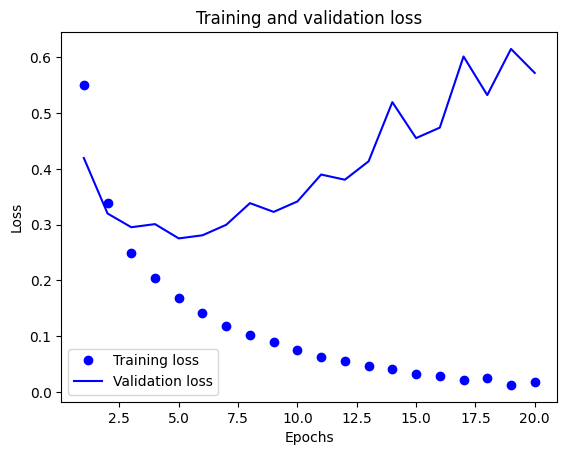

In [43]:
# Plot training and validation loss
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

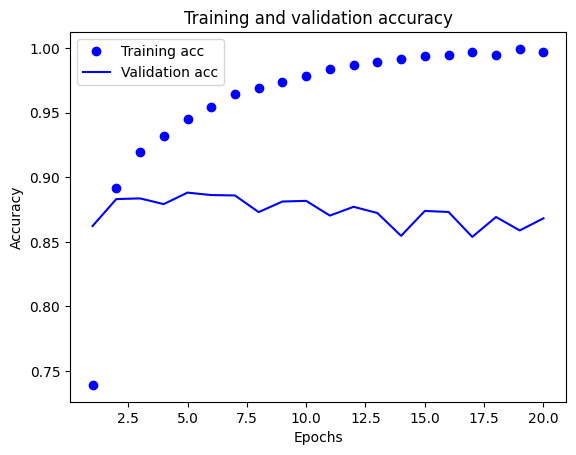

In [44]:
# Plot training and validation accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Multi-Class Classification

For the purposes of this example, we'll use the newswires (news update snippets) from the Reuters dataset

## Loading and Preparing the Dataset

The steps taken here are very similiar to the Binary Classification example with IMDB. We grab the 10 000 common words from the dataset, translate it into human-readable text, and multi-hot encode (vectorise) it with the previously declared function

In [60]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [62]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

We also encode the labels to prep them for Keras. There is a built in function for it, but it can also be done with a custom function. Both cane be found below

In [63]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

And, as before, we also save a validation set

In [68]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

## Creating the Model Architecture

In [66]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax") # Back to softmax, better for multiple classes
])

In [67]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy", # works better with one-hot encoded multiple classes
              metrics=["accuracy"])

In [69]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3598 - loss: 3.2735 - val_accuracy: 0.6050 - val_loss: 1.9285
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6525 - loss: 1.6674 - val_accuracy: 0.7020 - val_loss: 1.3845
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7399 - loss: 1.1873 - val_accuracy: 0.7390 - val_loss: 1.1945
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7997 - loss: 0.9477 - val_accuracy: 0.7660 - val_loss: 1.0889
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8234 - loss: 0.8169 - val_accuracy: 0.7840 - val_loss: 1.0073
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8640 - loss: 0.6554 - val_accuracy: 0.8030 - val_loss: 0.9808
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8846 - loss: 0.5564 - val_accuracy: 0.8060 - val_loss: 0.9199
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9044 - loss: 0.4634 - val_accuracy: 0.8190 - val_loss

# Regression

Neural Nets are subomptimal for regression tasks - approaches like Extreme Gradient Boosting work way better. Nevertheless, it can be useful to learn it. For this example, we'll use the Boston Housing Price Dataset

## Loading and Preparing the Dataset

In [70]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


The data is normalised in a more classic approach using the mean and standard deviation to scale it

In [71]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## Creating the Model Architecture

We use more regression-focused metrics - MSE for the loss function, MAE for the target metrics

In [72]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

We also implement k-fold cross validation to increase the robustness of the model. (May take ~30 seconds to run)

In [74]:
# Number of folds for cross-validation
k = 4

# Number of samples in each fold
num_val_samples = len(train_data) // k

# Number of epochs to train the model
num_epochs = 500

# List to store the mean absolute error (MAE) histories from each fold
all_mae_histories = []

# K-fold cross-validation
for i in range(k):
    print(f"Processing fold #{i}")
    
    # Preparing the validation data from the ith fold
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Preparing the training data by excluding the ith fold
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Building a new model instance
    model = build_model()
    
    # Training the model on the training data with validation data
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    # Retrieving the validation MAE history
    mae_history = history.history["val_mae"]
    
    # Storing the validation MAE history
    all_mae_histories.append(mae_history)
print("All folds processed")

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
All folds processed


Now, we can stitch together the MAE history of separate folds and plot it

In [75]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

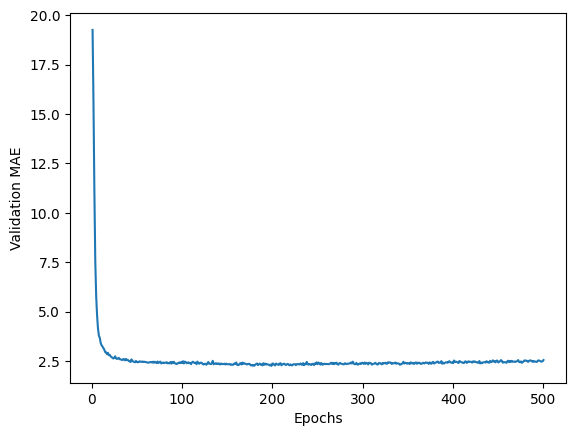

In [76]:
# Plotting validation scores
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Since the plot is a bit unreadable due to the fist few MAE points being so high, we can also show the plot without them

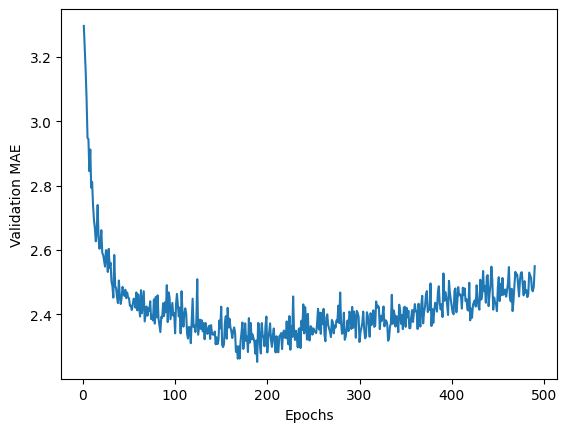

In [77]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# Additional Techniques

Those can be added to standard layers to tweak the way in which the model learns

## L1 and L2 Regularisers

Those can apply penalties on layer parameters, which essentially discourages the model from learning weights that are too large, instead focusing on the smaller weights

In [80]:
from tensorflow.keras import regularizers
regularizers.l1(0.001) # Apply L1 Regularisation
regularizers.l1_l2(l1=0.001, l2=0.001) # # Apply Both
regularizers.l2(0.002) # Apply L1 Regularisation
# The regularisation parameter should be tested with trial and error to obtain the best results

# Normally, you implement it like this:
#    layers.Dense(16,
#                 kernel_regularizer=regularizers.l2(0.002),
#                 activation="relu")

## Dropout

This can be used to randomly "switch off" a portion of the weights in a layer, which will force the network to optimise the remaining weights. This will make sure the model is more robust

In [82]:
# Add this below the desired layer:
# layers.Dropout(0.5)
# With the "0.5" being the percentage of switched off neurons

# Functional API

So far, every model has been created using Keras' basic Sequential API. However, for more complex approaches, however, the Functional API is required. The principles remain similiar, but the layers are formed with a completely new syntax. Below is a simple example of a NN with two dense layers made with this approach

In [84]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input layer with a shape of (3,) for data with 3 features
inputs = keras.Input(shape=(3,), name="my_input")

# Add a Dense layer with 64 neurons and ReLU
# This layer processes the inputs
features = layers.Dense(64, activation="relu")(inputs)

# Add another Dense layer with 10 units and softmax
# This layer generates the final outputs
outputs = layers.Dense(10, activation="softmax")(features)

# Create a Keras model by specifying the inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

The model can be further inspected with a few functions:

In [89]:
# Fetches the predefined shape of the expected inputs
inputs.shape

(None, 3)

In [88]:
# Fetches the datatype of the expected inputs
inputs.dtype

'float32'

In [93]:
# Same for features
print(features.shape)
print(features.dtype)

(None, 64)
float32


In [95]:
# Inspect the entire model
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_input (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

## Multi input, multi output

The Functional API is also very useful for models that have more than one input and more than one output. Below is an example of how this looks like in practice:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input dimensions
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# Define three different input layers
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# Combine the 'title', 'text_body', and 'tags' into a single tensor for a unified input
features = layers.Concatenate()([title, text_body, tags])

# Add a standard Dense layer
features = layers.Dense(64, activation="relu")(features)

# Add the first output layer for predicting binary classification (priority or not) with sigmoid
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)

# Add the second output layer for multi-class classification with softmax
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

# Create a Keras model by specifying the inputs and outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

and to train it, there are to approaches to passing the data. One includes passing the training data on its own, the other has it passing in the form of dictionaries

In [3]:
# Approach 1: Data on its own
import numpy as np

num_samples = 1280

# Generate training data randomly for the example
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# Same with testing
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

# Testing - note that two loss functions and two metrics are given
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

# Fitting - three inputs and two validation sets passed on here
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

# Evaluating
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - department_accuracy: 0.2177 - loss: 37.0052 - priority_mean_absolute_error: 0.4885
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - department_accuracy: 0.1267 - loss: 41.9958 - priority_mean_absolute_error: 0.5206 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [4]:
# Approach 2: Dictionaries
# (Run the above first)

model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - department_accuracy: 0.2480 - loss: 49.3174 - priority_mean_absolute_error: 0.5339    
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - department_accuracy: 0.0599 - loss: 48.0810 - priority_mean_absolute_error: 0.5206 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### Plotting Complex Models

To visualise some more complex multi input/multi output models, there exists a handy function

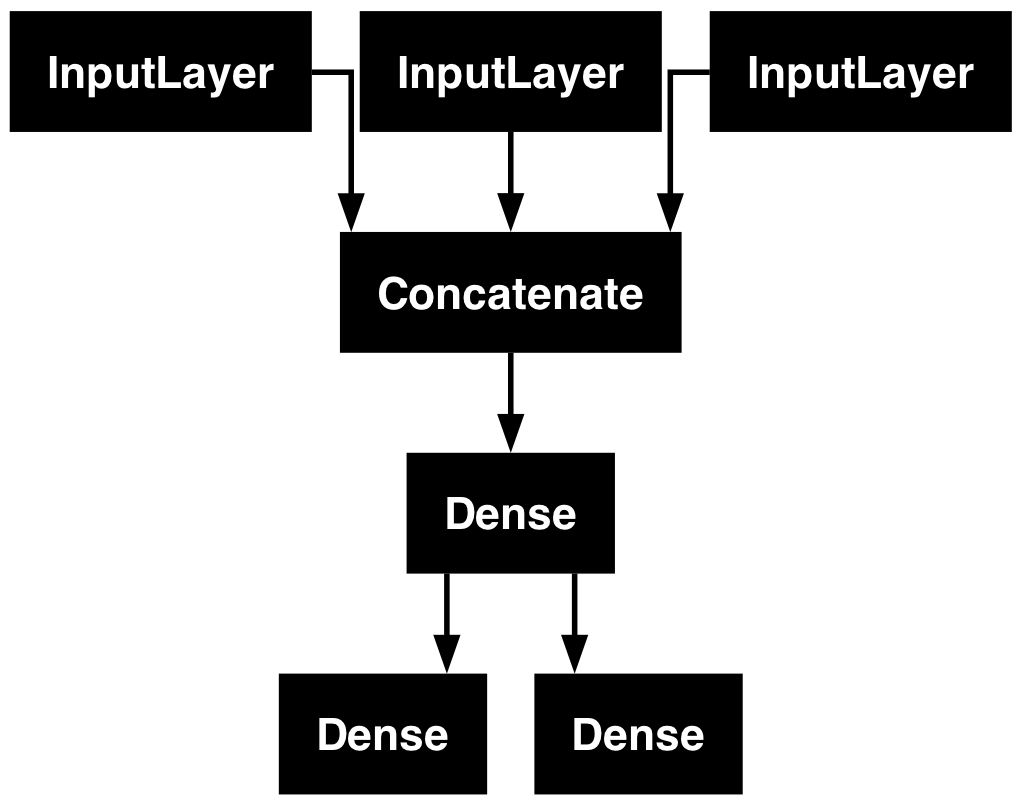

In [9]:
keras.utils.plot_model(model, "ticket_classifier.png")

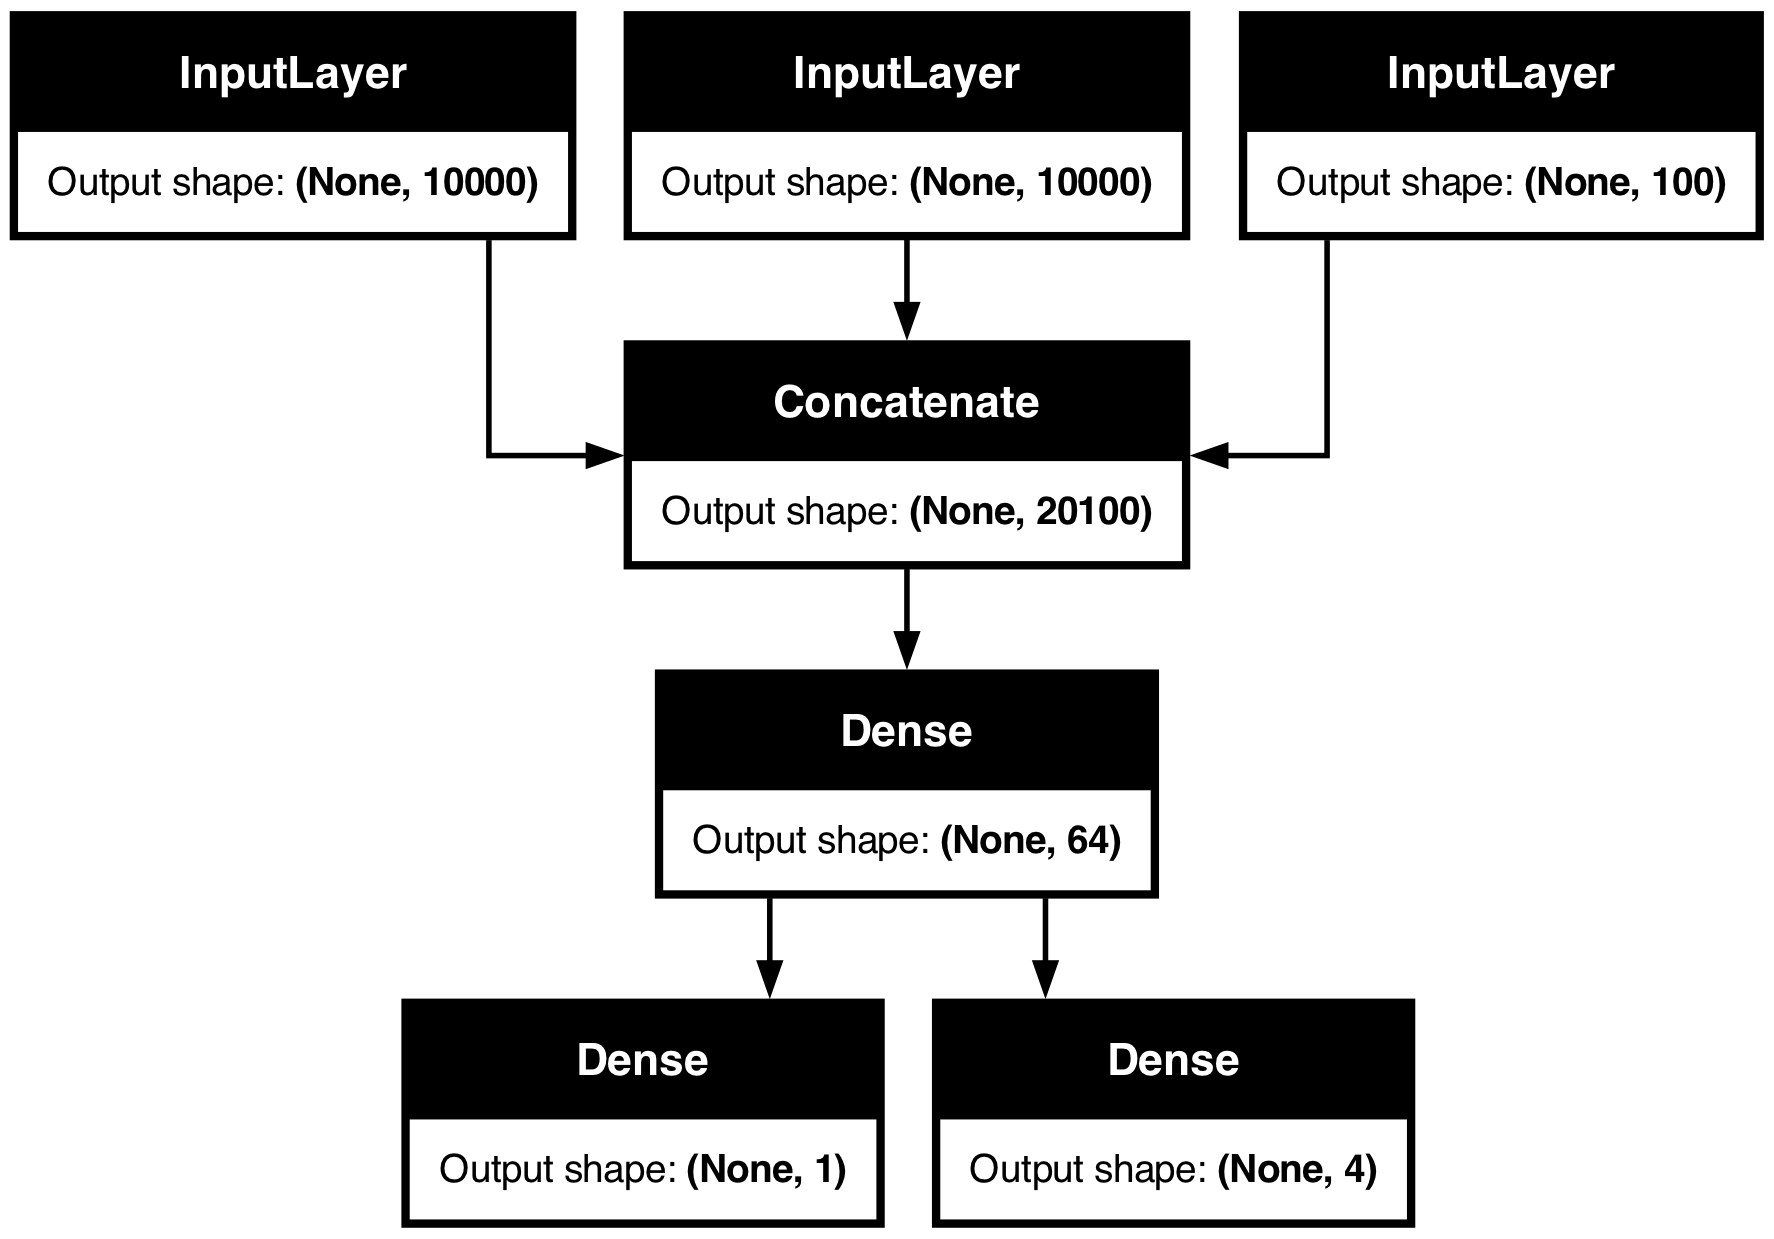

In [10]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

## Layer Connectivity

The Functional API allows fetching and manipulating individual model layers

In [14]:
# Fetch basic info about all layers
model.layers

[<InputLayer name=title, built=True>,
 <InputLayer name=text_body, built=True>,
 <InputLayer name=tags, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=priority, built=True>,
 <Dense name=department, built=True>]

In [17]:
# Input of a specfic layer
model.layers[3].input

[<KerasTensor shape=(None, 10000), dtype=float32, sparse=None, name=title>,
 <KerasTensor shape=(None, 10000), dtype=float32, sparse=None, name=text_body>,
 <KerasTensor shape=(None, 100), dtype=float32, sparse=None, name=tags>]

In [18]:
# Output of a specfic layer
model.layers[3].output

<KerasTensor shape=(None, 20100), dtype=float32, sparse=False, name=keras_tensor>

In [21]:
# Creating a new output based on an existing layers' output
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

# Calling the new output together with old ones
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

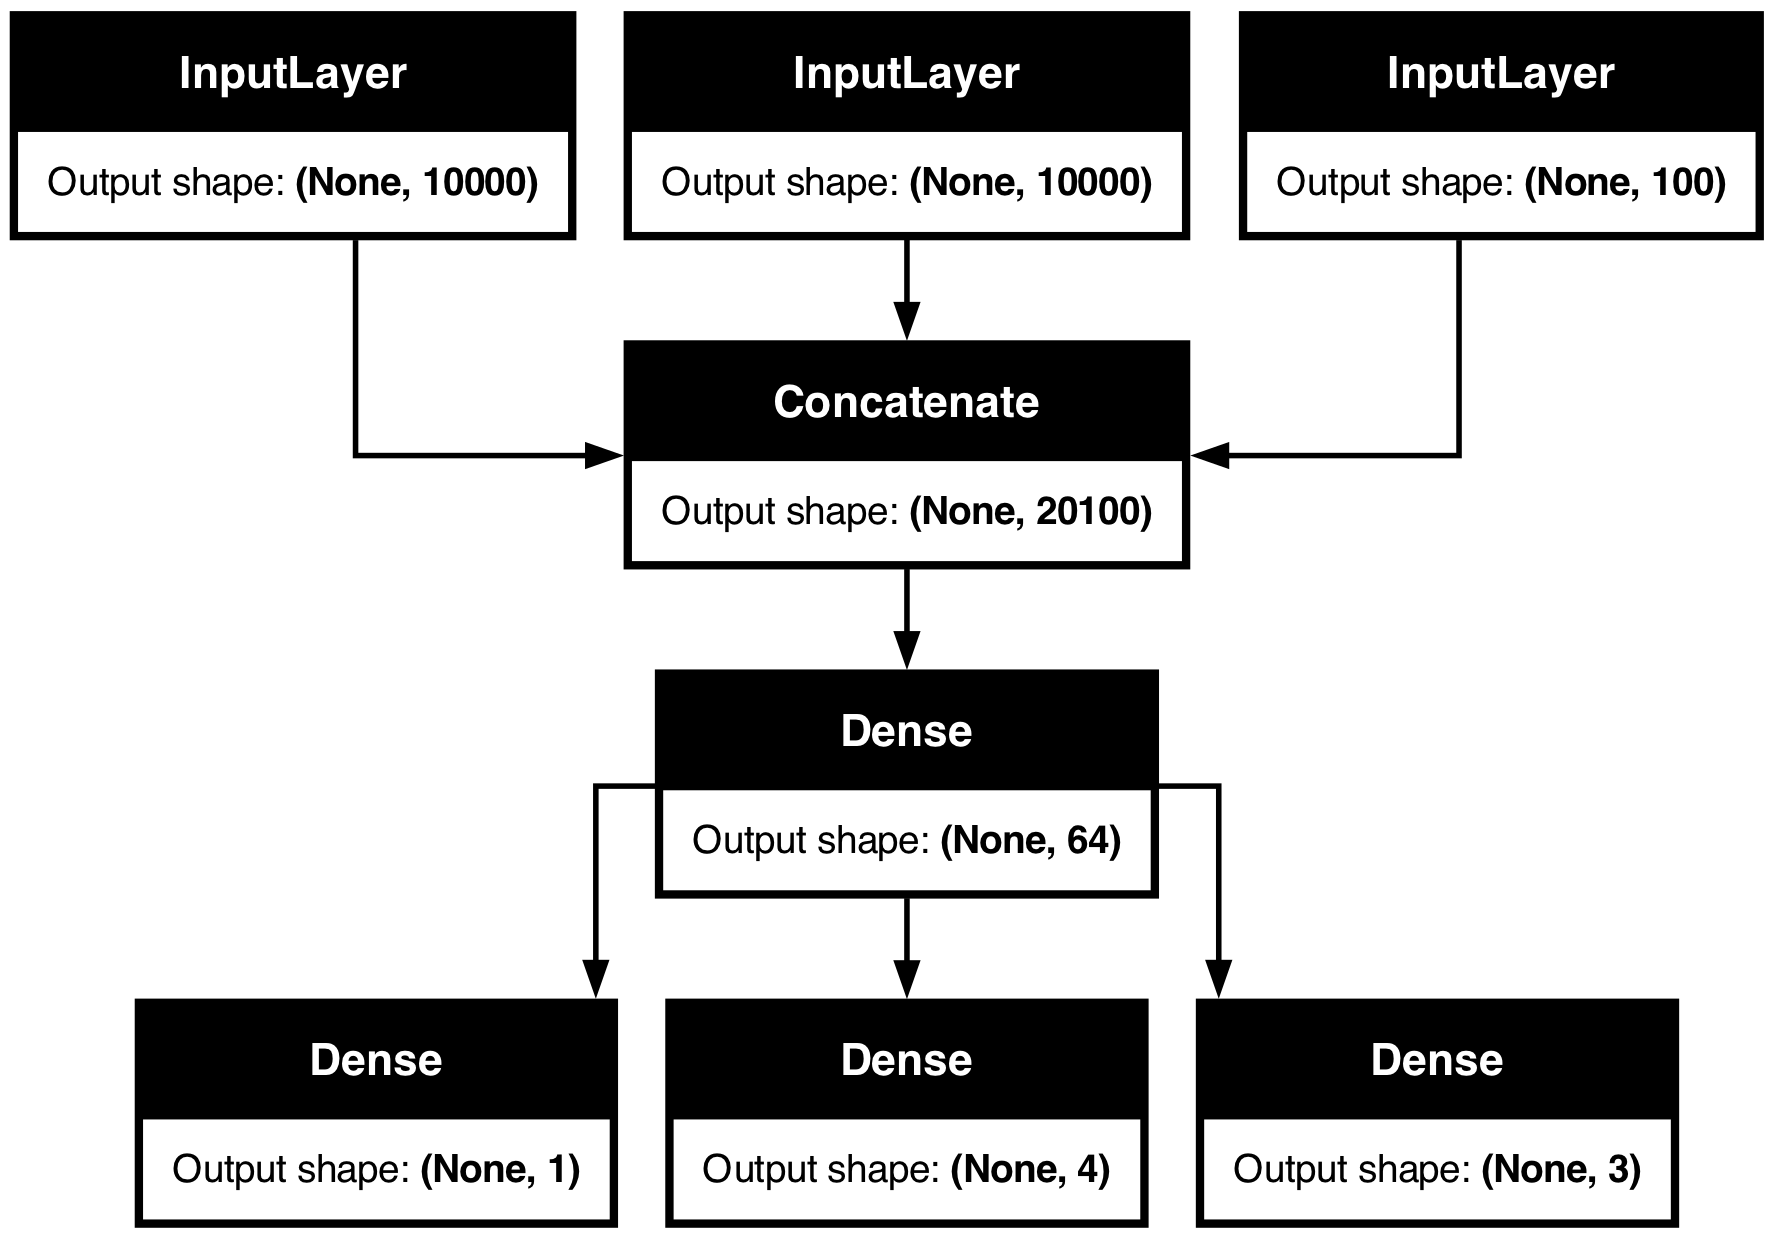

In [22]:
# To show the difference:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

# Subclassing

Subclassing is an even more in-depth approach than the Functional API. Essentailly, it allows everything to be written practically from scratch. Realistically, it only has a few fairly niche uses, but it is still valuable to learn about. Below is an example of using it to create a simple model:

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a custom model by subclassing tf.keras.Model
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        # Call the __init__ method of the parent class (tf.keras.Model)
        super().__init__()
        # Define a Concatenate layer to combine multiple inputs
        self.concat_layer = layers.Concatenate()
        # Define a Dense layer
        self.mixing_layer = layers.Dense(64, activation="relu")
        # Define a Dense layer for binary classification
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        # Define a Dense layer for multi-class classification
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    # Define the forward pass logic
    def call(self, inputs):
        # Extract individual inputs
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        # Concatenate the inputs
        features = self.concat_layer([title, text_body, tags])
        # Pass the concatenated features through the mixing layer
        features = self.mixing_layer(features)
        # Compute the priority score
        priority = self.priority_scorer(features)
        # Compute the department classification
        department = self.department_classifier(features)
        # Return both outputs
        return priority, department

After that, we continue in a fairly standard manner

In [25]:
# Call the function for 4 classes
model = CustomerTicketModel(num_departments=4)

# Pass the input data
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [26]:
# As in the multi input example:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)

model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2303 - loss: 36.8164 - mean_absolute_error: 0.4621
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5694 - loss: 39.4321 - mean_absolute_error: 0.4794 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Functional and Subclassing methods aren't mutually exclusive. You can create a subclassing layer within a functional model and vice versa

In [27]:
# Subclassing within Functional
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a custom subclassing layer
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        # Set number of units and activation function based on number of classes
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"  # Sigmoid activation for binary classification
        else:
            num_units = num_classes
            activation = "softmax"  # Softmax activation for multi-class classification
        # Define a Dense layer with appropriate number of units and activation function
        self.dense = layers.Dense(num_units, activation=activation)

    # Define the forward pass logic
    def call(self, inputs):
        # Pass the inputs through the Dense layer
        return self.dense(inputs)

# Main Functional body
# Define the input layer with a shape of (3,)
inputs = keras.Input(shape=(3,))

# Add a standard Dense layer
features = layers.Dense(64, activation="relu")(inputs)

# Use the custom sublassing layer to process the features
outputs = Classifier(num_classes=10)(features)

# Create a Keras model by specifying the inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

In [28]:
# Functional within Subclassing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the input layer with a shape of (64,)
inputs = keras.Input(shape=(64,))

# Add a Dense layer with 1 unit and sigmoid activation function for binary classification
outputs = layers.Dense(1, activation="sigmoid")(inputs)

# Create a binary classifier model using the inputs and outputs defined above
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

# Define a custom model by subclassing tf.keras.Model
class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        # Define a Dense layer
        self.dense = layers.Dense(64, activation="relu")
        # Use the previously defined binary_classifier model
        self.classifier = binary_classifier

    # Define the forward pass logic
    def call(self, inputs):
        # Pass the inputs through the Dense layer
        features = self.dense(inputs)
        # Pass the features through the binary classifier model
        return self.classifier(features)

# Instantiate the custom model
model = MyModel()

## Standard Workflow with Subclassing

The following explains how to implement standard functions like compile, fit, evaluate and predict with Subclassing. Essentially, for simple tasks, it is not so different that the previous approaches, it just allows for more flexibility and has a different syntax

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# Define a function to create the MNIST model
def get_mnist_model():
    # Define the input layer(28*28,)
    inputs = keras.Input(shape=(28 * 28,))
    # Add a standard Dense layer
    features = layers.Dense(512, activation="relu")(inputs)
    # Add a Dropout layer
    features = layers.Dropout(0.5)(features)
    # Add a Dense layer for multi classification
    outputs = layers.Dense(10, activation="softmax")(features)
    # Create a Keras model by specifying the inputs and outputs
    model = keras.Model(inputs, outputs)
    return model

# Load the MNIST dataset
(images, labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the images: reshape and normalize
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

# Split the data into training and validation sets
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

# Get the MNIST model
model = get_mnist_model()

# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train the model with training data and validate with validation data
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

# Evaluate the model on the test data
test_metrics = model.evaluate(test_images, test_labels)

# Predict the labels of the test images
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8640 - loss: 0.4503 - val_accuracy: 0.9541 - val_loss: 0.1571
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9510 - loss: 0.1659 - val_accuracy: 0.9678 - val_loss: 0.1160
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9639 - loss: 0.1279 - val_accuracy: 0.9726 - val_loss: 0.1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.9684 - loss: 0.1155
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


## Custom Metrics

These approaches allow to create different metrics than the standard accuracy or RMSE. This example shows how to recreate the standard RMSE metric with Subclassing

In [31]:
import tensorflow as tf
from tensorflow import keras

# Define a custom metric class
class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        # Call the __init__ method of the parent class (keras.metrics.Metric)
        super().__init__(name=name, **kwargs)
        # Initialize a state variable to keep track of the sum of MSEs
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        # Initialize a state variable to keep track of the total number of samples
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    # Update the state variables with the new batch of data
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert y_true to one-hot encoded vectors
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        # Compute the mean squared error for the batch
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        # Update the sum of MSEs
        self.mse_sum.assign_add(mse)
        # Get the number of samples in the batch
        num_samples = tf.shape(y_pred)[0]
        # Update the total number of samples
        self.total_samples.assign_add(num_samples)

    # Compute and return the result (root mean squared error)
    def result(self):
        # Compute the RMSE by dividing the sum of MSEs by the total number of samples
        # and taking the square root
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # Reset the state variables
    def reset_state(self):
        # Reset the sum of MSEs to zero
        self.mse_sum.assign(0.)
        # Reset the total number of samples to zero
        self.total_samples.assign(0)

It can then be called with:

In [34]:
model = get_mnist_model() # Model defined in previous section

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()]) # Calling on custom metric

# Below is the standard workflow
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8675 - loss: 0.4460 - rmse: 0.4358 - val_accuracy: 0.9558 - val_loss: 0.1545 - val_rmse: 0.2611
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9531 - loss: 0.1636 - rmse: 0.2690 - val_accuracy: 0.9653 - val_loss: 0.1203 - val_rmse: 0.2305
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9654 - loss: 0.1265 - rmse: 0.2360 - val_accuracy: 0.9704 - val_loss: 0.1078 - val_rmse: 0.2142
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.9691 - loss: 0.1093 - rmse: 0.2191


## Callbacks - EarlyStopping & ModelCheckpoint

Custom Callbacks allow you to execute specific actions at various stages of training, such as at the beginning or end of an epoch or batch, when training starts or ends, or even when the model is being saved or loaded. This way you can customize the training process by implementing custom behaviors like dynamic learning rate adjustment, logging metrics, modifying the model during training, early stopping or saving model checkpoints. The example below focuses on the latter two:

In [35]:
# Using two built in callbacks:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2, # How many epochs without improvement the model will wait
    ),
    keras.callbacks.ModelCheckpoint( # Saves the best model based on metric
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

model = get_mnist_model() # Model defined in earlier section

# Standard call
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list, # adding callbacks
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8664 - loss: 0.4481 - val_accuracy: 0.9560 - val_loss: 0.1551
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9535 - loss: 0.1625 - val_accuracy: 0.9701 - val_loss: 0.1061
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9625 - loss: 0.1289 - val_accuracy: 0.9739 - val_loss: 0.0999
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9691 - loss: 0.1117 - val_accuracy: 0.9752 - val_loss: 0.0939
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9730 - loss: 0.0970 - val_accuracy: 0.9750 - val_loss: 0.1007
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9739 - loss: 0.0940 - val_accuracy: 0.9781 - val_loss: 0.0918
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9767 - loss: 0.0829 - val_accuracy: 0.9799 - val_loss: 0.0918
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9775 - loss: 0.0850 - 

In [39]:
# Loading the checkpoint to get the model at best epoch
model = keras.models.load_model("checkpoint_path.keras")

It is also possible to write custom callbacks with Subclassing

In [40]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

# Define a custom callback to record and plot the training loss for each batch
class LossHistory(keras.callbacks.Callback):
    # Called at the beginning of training
    def on_train_begin(self, logs=None):
        # Initialize a list to store the loss for each batch
        self.per_batch_losses = []

    # Called at the end of each batch
    def on_batch_end(self, batch, logs=None):
        # Append the loss for the current batch to the list
        self.per_batch_losses.append(logs.get("loss"))

    # Called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # Clear the current figure
        plt.clf()
        # Plot the training loss for each batch
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        # Label the x-axis with the batch number and the current epoch
        plt.xlabel(f"Batch (epoch {epoch})")
        # Label the y-axis with "Loss"
        plt.ylabel("Loss")
        # Add a legend to the plot
        plt.legend()
        # Save the plot as an image file with a name indicating the epoch
        plt.savefig(f"plot_at_epoch_{epoch}")
        # Reset the list of batch losses for the next epoch
        self.per_batch_losses = []

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8629 - loss: 0.4458 - val_accuracy: 0.9578 - val_loss: 0.1463
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9522 - loss: 0.1665 - val_accuracy: 0.9663 - val_loss: 0.1171
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9633 - loss: 0.1275 - val_accuracy: 0.9719 - val_loss: 0.0976
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9692 - loss: 0.1097 - val_accuracy: 0.9740 - val_loss: 0.0994
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9733 - loss: 0.0977 - val_accuracy: 0.9735 - val_loss: 0.1000
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9737 - loss: 0.0925 - val_accuracy: 0.9764 - val_loss: 0.0972
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9761 - loss: 0.0861 - val_accuracy: 0.9777 - val_loss: 0.0985
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9800 - loss: 0.0740 - 

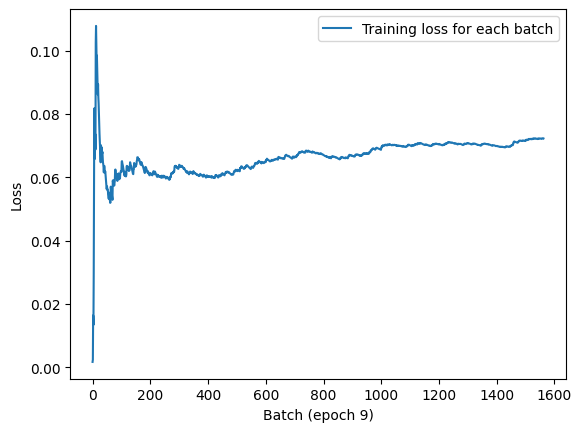

In [42]:
model = get_mnist_model() # Pre-defined model

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()], # Attach custom callback
          validation_data=(val_images, val_labels))

# Convolutional Neural Networks

This code will focus on implementation of computer vision with CNNs Below is the simplest example of a covnnet:

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

# Define input layer
inputs = keras.Input(shape=(28, 28, 1))

# Define two conv layers with pooling
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Define the final covn layer and flatten to get ready for classification
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# Softmax dense layer for classification
outputs = layers.Dense(10, activation="softmax")(x)

# Define full model
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

Training continues in a pretty standard manner:

In [47]:
from tensorflow.keras.datasets import mnist

# Load and prep example MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8847 - loss: 0.3704
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9860 - loss: 0.0446
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9902 - loss: 0.0307
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9940 - loss: 0.0201
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9945 - loss: 0.0159


And finally, evaluation:

In [48]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9891 - loss: 0.0381
Test accuracy: 0.992


## Data Augmentation

It allows for the training set to be made more difficult to read, which makes the network more likely to pick up on deeper, more complex features. There are many useful methods built into Keras:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a Sequential model for data augmentation
data_augmentation = keras.Sequential(
    [
        # Randomly flip images horizontally
        layers.RandomFlip("horizontal"),
        
        # Randomly rotate images by a factor of 0.1 (10% of 360 degrees)
        layers.RandomRotation(0.1),
        
        # Randomly zoom into images by a factor of 0.2
        layers.RandomZoom(0.2),
        
        # Randomly translate images horizontally and vertically by a factor of 0.2
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        
        # Randomly adjust the brightness of images
        layers.RandomBrightness(factor=0.2),
        
        # Randomly adjust the contrast of images
        layers.RandomContrast(factor=0.2),
        
        # Randomly apply a shear transformation to images
        layers.RandomShear(0.2),
        
        # Randomly crop images to a target size
        layers.RandomCrop(height=180, width=180),
        
        # Randomly rescale images
        layers.Rescaling(1.0 / 255),
    ]
)

# Afterwards, the data augmentation layer can be added to any model
model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),
    data_augmentation,  # Data augmentation layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Or
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) # Data augmentation layer
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Display augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Image Segmentation

Image segmentation is one of the core computer vision tasks. What is important to remember is its unique approach to downsampling. Instead of flattening, it uses transposed convolution layers with strides (the number of pixels the model "jumps over" instead of getting to the immediate one), which effectively bring the input size down to the desired tensor

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# Define a function to create a model
def get_model(img_size, num_classes):
    # Define the input layer with the shape of image size plus 3 RGB color channels
    inputs = keras.Input(shape=img_size + (3,))
    
    # Normalise the input values to the range [0, 1] by dividing by 255
    x = layers.Rescaling(1./255)(inputs)

    # Normal convolution layers
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # downsampling with transposed conv layers
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Create the model
    model = keras.Model(inputs, outputs)
    return model

# Define the image size and number of classes
img_size = (180, 180)
num_classes = 3

# Create the model
model = get_model(img_size=img_size, num_classes=num_classes)

# Print the model summary to see the architecture
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 90, 90, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 23, 23, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 23, 23, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 46, 46, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 46, 46, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 92, 92, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 92, 92, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 184, 184, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 184, 184, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

## Other Architecture Elements

### Residual Connections

Shortcuts in the model that add the input of a layer to its output which allows the gradient to flow more freely through deep networks and noisy layers. Simplest implementation:

In [ ]:
# Copy this into a model
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x # Take the output of the last layer
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual) # match the channel of the target layer
x = layers.add([x, residual]) # create the connection

If the conv layer is followed by a pooling layer, the matter is also easy to resolve

In [ ]:
# Copy this into a model
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x) # notice the "2" here
residual = layers.Conv2D(64, 1, strides=2)(residual) # Stride should match the degree of pooling
x = layers.add([x, residual])

In [ ]:
# As a function to create a whole residual block instantly
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

# Example usage
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

### Batch Normalisation

Allows for normalisation (standard mean and variance kind, not rescaling) as a standard model layer

In [14]:
# Copy this into a model
x = layers.BatchNormalization()(x)

# Pre-trained Models

How to access existing architectures and use them for new tasks. This example includes the VGG16 architecture

In [4]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", # Which pre trained weights to use
    include_top=False, # To exclude the dense layers at the top of the model
    input_shape=(180, 180, 3)) # Define the input shape

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

This step includes extracting features using the conv base of VGG16. In essence, this puts all the images through the model and returns them in a form that will be much easier to process for a different model

In [ ]:
import numpy as np

# Define a function to extract features and labels from a dataset using VGG16
def get_features_and_labels(dataset):
    all_features = [] # List to store features
    all_labels = [] # List to store labels
    
    # Iterate over the dataset
    for images, labels in dataset:
        # Preprocess the images using VGG16's preprocessing function
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        
        # Use the convolutional base to predict the features for the preprocessed images
        features = conv_base.predict(preprocessed_images)
        
        # Append the extracted features and corresponding labels to the lists
        all_features.append(features)
        all_labels.append(labels)
    
    # Concatenate the list of features and labels into numpy arrays
    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features and labels for the training dataset
train_features, train_labels = get_features_and_labels(train_dataset)

# same for the validation dataset
val_features, val_labels = get_features_and_labels(validation_dataset)

# same for the test dataset
test_features, test_labels = get_features_and_labels(test_dataset)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input layer
inputs = keras.Input(shape=(5, 5, 512))

# Flatten the input tensor (since it comes from a conv base)
x = layers.Flatten()(inputs)

# Create the top of the network
# Add a dense layer with dropout
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

# Add the output layer with sigmoid for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Compile
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

# Training
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

## Freezing and Fine-Tuning the Conv Base

Pre-trained models can be used as part of a normal model (without extracting the features first) if their layers are frozen - restricted from training

In [11]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False # To initiate freezing - stop training

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Another approach is fine-tuning, which consists of freezing all layers except for the top ones. This essentially allows for the model to readjust to the problem (dataset) at hand, while still maining most of its original feature extraction capabilities

In [10]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# Time-Series with RNNs

Recurrent Neural Networks are perfect for time series tasks. The example below uses the Jena Climate dataset

In [ ]:
# To load the dataset from an external csv
import os

fname = os.path.join("jena_climate_2009_2016.csv")

# Open the file and read its content
with open(fname) as f:
    data = f.read()

# Split the data into lines
lines = data.split("\n")

# Extract the header from the first line
header = lines[0].split(",")

# Remove the header from the lines, keeping only the data rows
lines = lines[1:]

# Print the header to show the column names
print(header)

# Print the number of data rows
print(len(lines))


In [ ]:
# Splitting into training, testing and validation sets

# Define the sampling rate and sequence length for the time series data
sampling_rate = 6
sequence_length = 120

# Calculate the delay, which determines the offset for the target values
delay = sampling_rate * (sequence_length + 24 - 1)

# Define the batch size for the dataset
batch_size = 256

# Create the training dataset using timeseries_dataset_from_array
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay], # Input data, excluding the delayed portion at the end
    targets=temperature[delay:], # Target data, starting after the delay
    sampling_rate=sampling_rate, # Interval between successive data points
    sequence_length=sequence_length, # Length of the output sequences
    shuffle=True, # Shuffle the dataset
    batch_size=batch_size, # Number of samples per batch
    start_index=0, # Starting index of the dataset
    end_index=num_train_samples  # Ending index for the training data
)

# Create the validation dataset
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples, # Starting index of the validation data
    end_index=num_train_samples + num_val_samples # Ending index for the validation data
)

# Create the test dataset
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples # Starting index of the test data, end index is end of array by default
)

## LSTM Layer

The simplest form of an RNN is an LSTM (Long Short-Term Memory) layer, which is designed to capture long-term dependencies in sequential data. LSTMs are particularly effective for time series prediction tasks because they can retain information from previous inputs over longer periods

In [ ]:
# Implementing a simple LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) # Define the input shape for the model
x = layers.LSTM(16)(inputs) # Add an LSTM layer
outputs = layers.Dense(1)(x) # Add a standard Dense layer
model = keras.Model(inputs, outputs) # Create the model

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

# Compile the model with MSE and MAE (for timeseries)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Training
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Load the best model from checkpoint
model = keras.models.load_model("jena_lstm.keras")

# Evaluate the model on the test dataset and print MAE
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

## RNN Layers

Here's how to add many types of RNN layers

In [ ]:
# Drop this into a model
# An RNN layer that can process sequences of any length
num_features = 14
inputs = keras.Input(shape=(None, num_features)) # Define the input shape with variable sequence length
outputs = layers.SimpleRNN(16)(inputs) # Add a SimpleRNN layer with 16 units

# An RNN layer that returns only its last output step
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features)) # Define the input shape with fixed sequence length of 120
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs) # Add a SimpleRNN layer that returns only the last output

# An RNN layer that returns its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features)) # Define the input shape with fixed sequence length of 120
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs) # Add a SimpleRNN layer that returns the full sequence

# Stacking RNN layers
inputs = keras.Input(shape=(steps, num_features)) # Define the input shape with fixed sequence length of 120
x = layers.SimpleRNN(16, return_sequences=True)(inputs) # First SimpleRNN layer returning full sequence
x = layers.SimpleRNN(16, return_sequences=True)(x) # Second SimpleRNN layer returning full sequence
outputs = layers.SimpleRNN(16)(x) # Third SimpleRNN layer returning only the last output

## GRU and Bidirectional RNNs

Another useful element is GRU layers and bidrectional RNNs

In [ ]:
# Model with GRU layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Model with bidirectional RNNs
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Text DL

This section concerns all matters related to incorporating text in Neural Nets

## Text Vectorisation

The process of transforming text into a machine readable format. Below are many useful functions:

In [16]:
import string

class Vectorizer:
    def standardize(self, text):
        # Convert text to lowercase and remove punctuation
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        # Standardize the text and split it into tokens (words)
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        # Initialize the vocabulary with special tokens
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            # Standardize and tokenize each text in the dataset
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                # Add each unique token to the vocabulary
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        # Create an inverse vocabulary for decoding
        self.inverse_vocabulary = dict((v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        # Standardize and tokenize the input text, then convert tokens to integers
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens] # Use [UNK] token for unknown words

    def decode(self, int_sequence):
        # Convert a sequence of integers back into a string using the inverse vocabulary
        return " ".join(self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

# Create an instance of the Vectorizer class
vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
# Build the vocabulary from the dataset
vectorizer.make_vocabulary(dataset)

# Encode a test sentence into a sequence of integers
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

# Decode the sequence of integers back into a string
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

[2, 3, 5, 7, 1, 5, 6]
i write rewrite and [UNK] rewrite again


It can also be done using some built-in TensorFlow functionality

In [18]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",
)

import re
import string
import tensorflow as tf

# Custom function to standardize the text: lowercase and remove punctuation
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", ""
    )

# Custom function to split the text into tokens (words)
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

# Create a TextVectorization layer with custom standardization and split functions
text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

# Dataset of sentences to adapt the TextVectorization layer
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

# Adapt the TextVectorization layer to the dataset to build the vocabulary
text_vectorization.adapt(dataset)

# Get the vocabulary from the TextVectorization layer
vocabulary = text_vectorization.get_vocabulary()
print(vocabulary) # Print the vocabulary to see the token-index mapping

# Encode a test sentence using the TextVectorization layer
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence) # Print the encoded sentence (sequence of integers)

# Decode the encoded sentence back into a string using the vocabulary
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence) # Print the decoded sentence

['', '[UNK]', 'erase', 'write', 'then', 'rewrite', 'poppy', 'i', 'blooms', 'and', 'again', 'a']
tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)
i write rewrite and [UNK] rewrite again


## N-grams

Another approach to encoding data are n-grams, which store words together with their 'n' closest neighbours

### Unigram

In [ ]:
# Training a unigram model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers

# Create a TextVectorization layer with a maximum of 20,000 tokens and multi-hot encoding
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)

# Extract only the text data from the training dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

# Adapt the TextVectorization layer to the text data to build the vocabulary 
text_vectorization.adapt(text_only_train_ds)

# Map the text data through the TextVectorization layer to translate into binary multi-hot encoded
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

# Define a function to create a simple NN
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs) # Create the model
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Instantiate and summarize the model
model = get_model()
model.summary()

# Define callbacks, including a ModelCheckpoint to save the best model during training
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras", save_best_only=True)
]

# Train the model with the training dataset, validating with the validation dataset
model.fit(
    binary_1gram_train_ds.cache(), # Cache the training dataset for better performance
    validation_data=binary_1gram_val_ds.cache(), # Cache the validation dataset
    epochs=10,
    callbacks=callbacks
)

# Load the best saved model
model = keras.models.load_model("binary_1gram.keras")

# Evaluate the model on the test dataset and print the test accuracy
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

### Bigram

In [ ]:
# Bigram model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers

# Create a TextVectorization layer with bigrams, a maximum of 20,000 tokens, and multi-hot encoding
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

# Adapt the TextVectorization layer to the text data from the training dataset
text_vectorization.adapt(text_only_train_ds)

# Map the text data through the TextVectorization
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

# Define a function to create a simple NN
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Instantiate and summarize the model
model = get_model()
model.summary()

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras", save_best_only=True)
]

# Train the model
model.fit(
    binary_2gram_train_ds.cache(),
    validation_data=binary_2gram_val_ds.cache(),
    epochs=10,
    callbacks=callbacks
)

# Load the best saved model
model = keras.models.load_model("binary_2gram.keras")

# Evaluate the model on the test dataset and print the test accuracy
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

### Bigram (TF-IDF)

In [ ]:
# Bigram
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Create a TextVectorization layer with 2-grams, a maximum of 20,000 tokens, and TF-IDF
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

# Adapt the TextVectorization layer to the text data from the training dataset
text_vectorization.adapt(text_only_train_ds)

# Map the text data through the TextVectorization layer
tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

# Define a function to create a simple NN
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Instantiate and summarize the model
model = get_model()
model.summary()

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras", save_best_only=True)
]

# Train the model
model.fit(
    tfidf_2gram_train_ds.cache(),
    validation_data=tfidf_2gram_val_ds.cache(),
    epochs=10,
    callbacks=callbacks
)

# Load the best saved model
model = keras.models.load_model("tfidf_2gram.keras")

# Evaluate the model on the test dataset and print the test accuracy
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

# Final implementation
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs) # Process the raw text input
outputs = model(processed_inputs) # Get the model's prediction
inference_model = keras.Model(inputs, outputs)

# Test the inference model with raw text data
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive") # Print the prediction as a percentage

# Sequence Models

Sequence models preserve word order further than n-grams

## Basic Implementation

In [ ]:
# Loading words as sequences
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000

# Create a TextVectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens, # Maximum number of unique tokens (words) to keep, any tokens beyond this will be discarded
    output_mode="int", # Encode each token as an integer index
    output_sequence_length=max_length, # Pad or truncate the sequences to a fixed length
)

text_vectorization.adapt(text_only_train_ds)

# Continue as before
# Create train, test and val sets
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

## Word Embeddings

In [ ]:
from tensorflow.keras import layers, keras

# Create an Embedding layer
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

# Define the input layer, expecting inputs defined from last code blocks
inputs = keras.Input(shape=(None,), dtype="int64")

# Pass the input through the Embedding layer
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)

# Add a Bidirectional LSTM layer with droput
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

# Define the output layer
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Compile
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model.summary()

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]

# Training
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Load the best saved model
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

### Masking

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(None,), dtype="int64")

# Apply the Embedding layer with masking enabled (mask_zero=True)
embedded = layers.Embedding(
    input_dim=max_tokens, 
    output_dim=256, 
    mask_zero=True
)(inputs)

# Proceed as before
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras", save_best_only=True)
]

model.fit(
    int_train_ds, 
    validation_data=int_val_ds, 
    epochs=10, 
    callbacks=callbacks
)

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

### Pre-trained Embeddings (GloVe)

In [ ]:
# Fetching the embeddings index from pre-downloaded model
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

# Turn the embeddings into a Keras compatible format
embedding_dim = 100 # dimensions of the embeddings

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the embedding layer
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Create the model with the embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Transformers

I'm purposefully keeping this section almost empty, since the implementation of Transformers is hard to create templates for - they mostly all require at least some degree of subclassing and internal tweaking.

## Basic Implementation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a custom TransformerEncoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # Multi-head attention mechanism
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Dense projection layers
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        # Layer normalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        # Apply multi-head attention
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        # Add & Normalize
        proj_input = self.layernorm_1(inputs + attention_output)
        # Apply dense projection and normalize again
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Define a custom PositionalEmbedding layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# Hyperparameters
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

# Define the model
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model.summary()

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras", save_best_only=True)
]

# Train the model
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)

# Load the best saved model
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")